## Spectrogram Visualizer
The following notebook enables one to visualize the spectrogram he/she will get during trainig. This code aims to mimic the "getitem" functionalities, and show the spectrogram the model gets

In [1]:
import sys
from pathlib import Path
import yaml
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import librosa.display


sys.path.append('..')

In [2]:
from soundbay.data import ClassifierDataset

In [3]:
## utils

class DotDictWrapper:
    """
    d['key']==d.key
    """
    def __init__(self, d):
        self._dict = d

    def __getattr__(self, name):
        if name in self._dict:
            return self._dict[name]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

    def __getitem__(self, key):
        return self._dict[key]

### Your params here

In [17]:
DATA_PATH = '/home/azureuser/soundbay/datasets/shaye_dataset/shaye_cods_data'
METADATA_PATH = '/home/azureuser/soundbay/datasets/shaye_dataset/shaye_annotations_train_val_noleak.csv'

# load augmentation and preprocessors - you can choose what yaml file to load by changing the path below
with open('../soundbay/conf/preprocessors/_mel_preprocessors.yaml', 'r') as file:
    preprocessors = yaml.safe_load(file)
with open('../soundbay/conf/augmentations/_augmentations.yaml', 'r') as file:
    augmentations = yaml.safe_load(file)
with open('../soundbay/conf/data/defaults.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
data = data['data']
preprocessors=preprocessors['_preprocessors']
augmentations = augmentations['_augmentations']

In [18]:
preprocessors

{'mel_spectrogram': {'_target_': 'torchaudio.transforms.MelSpectrogram',
  'sample_rate': '${data.sample_rate}',
  'n_fft': '${data.n_fft}',
  'hop_length': '${data.hop_length}',
  'win_length': '${data.n_fft}',
  'pad_mode': 'constant',
  'n_mels': 64,
  'f_min': '${data.min_freq}',
  'f_max': '${data.max_freq}'},
 'amplitude_2_db': {'_target_': 'torchaudio.transforms.AmplitudeToDB'},
 'peak_norm': {'_target_': 'soundbay.data.PeakNormalize'}}

In [20]:
pprint(data)

{'batch_size': 64,
 'data_sample_rate': 44100,
 'hop_length': 256,
 'label_names': ['Noise', 'Call'],
 'max_freq': 8000,
 'min_freq': 0,
 'n_fft': 1024,
 'num_workers': 10,
 'sample_rate': 16000,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                   'augmentations': '${_augmentations}',
                   'augmentations_p': 0.8,
                   'data_path': './tests/assets/data/',
                   'data_sample_rate': '${data.data_sample_rate}',
                   'margin_ratio': 0.5,
                   'metadata_path': './tests/assets/annotations/sample_annotations.csv',
                   'mode': 'train',
                   'preprocessors': '${_preprocessors}',
                   'sample_rate': '${data.sample_rate}',
                   'seq_length': 1,
                   'slice_flag': False},
 'val_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                 'augmentations': None,
                 'augmentations_p': 0,
                

In [21]:
## you can tune the parameters from here, or you can change them in the yaml files and then load again
print(f"before: {data['data_sample_rate']}")
data['data_sample_rate'] = 16000
data["sample_rate"] = 2000
print(f"after: {data['data_sample_rate']}")

before: 44100
after: 16000


In [22]:
data['max_freq'] = 1000
data['augmentations_p'] = 0
data['hop_length'] = 64
data['train_dataset']['seq_length'] = 1
data['val_dataset']['seq_length'] = 1

# preprocessors['mel_spectrogram']['n_mels'] = 64
data['n_fft'] = 512

In [23]:
data

{'label_names': ['Noise', 'Call'],
 'batch_size': 64,
 'num_workers': 10,
 'sample_rate': 2000,
 'data_sample_rate': 16000,
 'min_freq': 0,
 'max_freq': 1000,
 'n_fft': 512,
 'hop_length': 64,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
  'data_path': './tests/assets/data/',
  'mode': 'train',
  'metadata_path': './tests/assets/annotations/sample_annotations.csv',
  'augmentations_p': 0.8,
  'augmentations': '${_augmentations}',
  'preprocessors': '${_preprocessors}',
  'seq_length': 1,
  'margin_ratio': 0.5,
  'data_sample_rate': '${data.data_sample_rate}',
  'sample_rate': '${data.sample_rate}',
  'slice_flag': False},
 'val_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
  'data_path': './tests/assets/data',
  'mode': 'val',
  'metadata_path': './tests/assets/annotations/sample_annotations.csv',
  'augmentations_p': 0,
  'augmentations': None,
  'preprocessors': '${_preprocessors}',
  'seq_length': 1,
  'margin_ratio': 0,
  'data_sample_rate': '${data

In [24]:
aggr_conf = OmegaConf.create({'data':data, 'preprocessors':preprocessors, 'augmentations':augmentations})

In [25]:
cfg = DotDictWrapper({
    'data_path': DATA_PATH,
    'metadata_path': METADATA_PATH,
    'augmentations': aggr_conf.augmentations,
    'augmentations_p': aggr_conf.data.val_dataset.augmentations_p,
    'preprocessors': aggr_conf.preprocessors,
    'seq_length': aggr_conf.data.val_dataset.seq_length,
    'data_sample_rate': aggr_conf.data.data_sample_rate,
    'sample_rate': aggr_conf.data.sample_rate,
    'mode': "val",
    'slice_flag': False,
    'margin_ratio': 0,
    'split_metadata_by_label': False,
})

# cfg_val = ... 

# initiate the dataset

dataset_train = ClassifierDataset(cfg.data_path, cfg.metadata_path, cfg.augmentations, cfg.augmentations_p, cfg.preprocessors,
                 cfg.seq_length, cfg.data_sample_rate, cfg.sample_rate, cfg.mode,
                 cfg.slice_flag, cfg.margin_ratio, cfg.split_metadata_by_label)

In [26]:
dataset_train.metadata.head()

,Unnamed: 0,Unnamed: 0.1,filename,call_length,begin_time,end_time,label,annotations_filename,s3_path,split_type
0,0,0,7205.230411230503,84.00041,155.34249,239.3429,0,FlumeL_m_23.04.11.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
1,1,1,7205.230415030015,52.63660,67.96760,120.6042,0,FlumeL_m_23.04.11.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
2,2,2,7205.230417010023,145.71480,105.06910,250.7839,0,FlumeL_m_23.04.11.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
3,4,4,7205.230421010039,5.30740,63.55380,68.8612,0,FlumeL_m_23.04.11.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
4,5,5,7205.230423210051,59.04170,37.29640,96.3381,0,FlumeL_m_23.04.11.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train


___
---

### Functionalities from getitem

In [27]:
"""
__getitem__ method loads item according to idx from the metadata
path_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)
audio = self._get_audio(path_to_file, begin_time, end_time, label, channel)
audio_raw = self.sampler(audio)
audio_augmented = self.augment(audio_raw)
audio_processed = self.preprocessor(audio_augmented)
"""

'\n__getitem__ method loads item according to idx from the metadata\npath_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)\naudio = self._get_audio(path_to_file, begin_time, end_time, label, channel)\naudio_raw = self.sampler(audio)\naudio_augmented = self.augment(audio_raw)\naudio_processed = self.preprocessor(audio_augmented)\n'

In [28]:
def show_spectrogram(audio_processed, title, label):
    plt.figure()
    librosa.display.specshow(audio_processed)
    plt.title(f"{str(title)} label: {label}")
    plt.show()

In [29]:
indices_to_check = [120,121]

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 64, 32])
name: /home/azureuser/soundbay/datasets/shaye_dataset/shaye_cods_data/7205.230518005829.wav


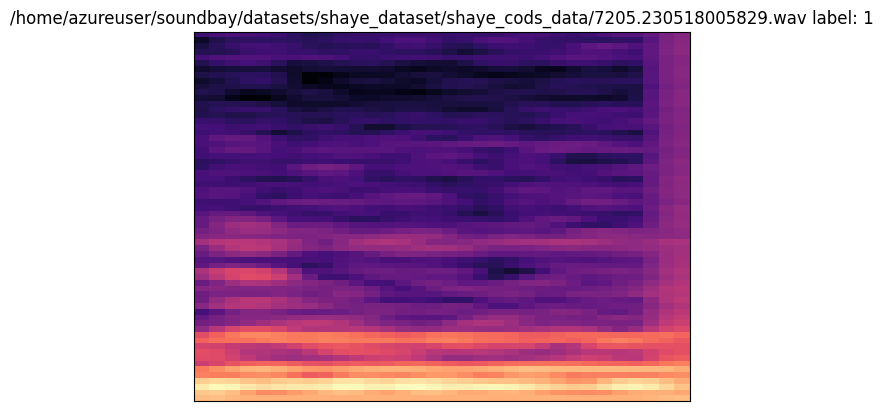

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 64, 32])
name: /home/azureuser/soundbay/datasets/shaye_dataset/shaye_cods_data/6953.230331150111.wav


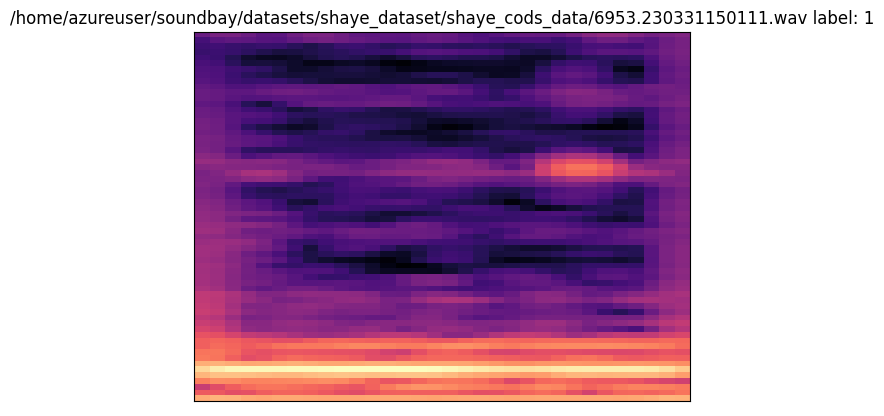

Bad pipe message: %s [b'\xc8\xa5e\xa0\x92\x1f\x10\xfbhq\xbd\x95\xc4d\xc2\xad\xa0O\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0', b"/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x00"]
Bad pipe message: %s [b'8\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00']
Bad pipe message: %s [b'\x00\t127.0.0.1']
Bad pipe message: %s [b'n\xaa\x93pG\xdb\xb9\xf6\x04"\x08\x16\xae\x15\xcc_cH\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0\'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t

In [30]:
for idx in indices_to_check:
    path_to_file, begin_time, end_time, label, channel = dataset_train._grab_fields(idx)
    audio = dataset_train._get_audio(path_to_file, begin_time, end_time, label, channel)
    print(f"audio.shape: {audio.shape}")
    audio_raw = dataset_train.sampler(audio)
    print(f"audio_raw.shape: {audio_raw.shape}")
    audio_augmented = dataset_train.augment(audio_raw)
    print(f"audio_augmented.shape: {audio_augmented.shape}")
    audio_processed = dataset_train.preprocessor(audio_augmented)
    print(f"audio_processed.shape: {audio_processed.shape}")
    print(f"name: {path_to_file}")
    audio_processed = audio_processed.squeeze().cpu().numpy()
    show_spectrogram(audio_processed, title=path_to_file, label=label)

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 257, 32])
name: /home/azureuser/soundbay/datasets/shaye_dataset/shaye_cods_data/7205.230518005829.wav


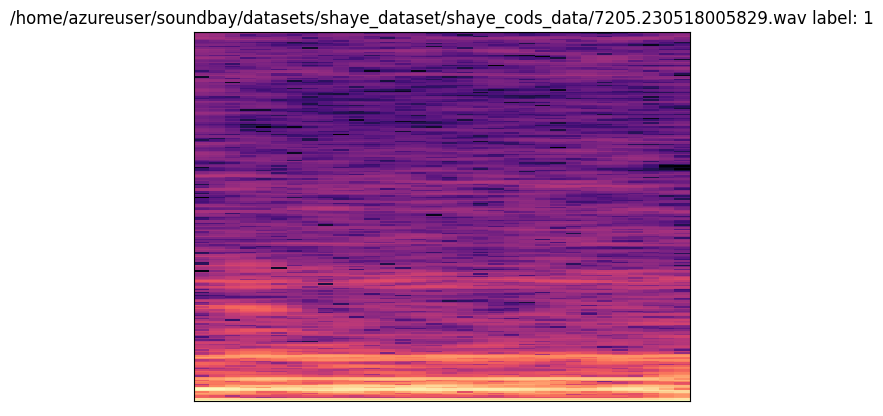

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 257, 32])
name: /home/azureuser/soundbay/datasets/shaye_dataset/shaye_cods_data/6953.230331150111.wav


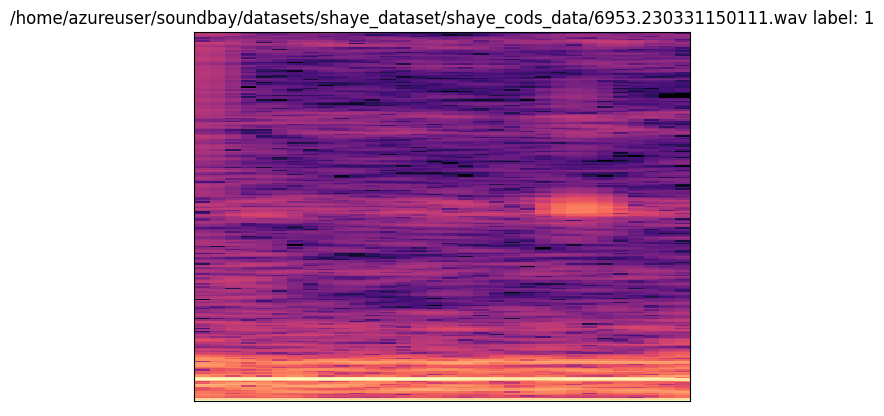

In [16]:
for idx in indices_to_check:
    path_to_file, begin_time, end_time, label, channel = dataset_train._grab_fields(idx)
    audio = dataset_train._get_audio(path_to_file, begin_time, end_time, label, channel)
    print(f"audio.shape: {audio.shape}")
    audio_raw = dataset_train.sampler(audio)
    print(f"audio_raw.shape: {audio_raw.shape}")
    audio_augmented = dataset_train.augment(audio_raw)
    print(f"audio_augmented.shape: {audio_augmented.shape}")
    audio_processed = dataset_train.preprocessor(audio_augmented)
    print(f"audio_processed.shape: {audio_processed.shape}")
    print(f"name: {path_to_file}")
    audio_processed = audio_processed.squeeze().cpu().numpy()
    show_spectrogram(audio_processed, title=path_to_file, label=label)

In [228]:
import pandas as pd
df = pd.read_csv(METADATA_PATH)


In [244]:
df[df['filename'] == 7205.230518005829]

,Unnamed: 0,Unnamed: 0.1,filename,call_length,begin_time,end_time,label,annotations_filename,s3_path,split_type
32,41,41,7205.230518,67.3387,147.3014,214.6401,0,FlumeL_m_23.05.09.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
126,146,146,7205.230518,0.2521,147.0493,147.3014,1,FlumeL_m_23.05.09.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
162,192,192,7205.230518,0.2419,214.6401,214.8820,1,FlumeL_m_23.05.09.Sounds.selections_DV.txt,s3://deepvoice-user-uploads/shayetudor@gmail.c...,train
